# Hybrid Forgery Training + Evaluation
This notebook lets you tune every training hyperparameter, toggle ablation flags, and launch `run_training` with tqdm progress bars. After training, reuse the same configuration to load checkpoints, compute metrics (Dice/IoU/precision/recall/F1 + confusion matrix), and visualize 10 qualitative test samples with image / ground-truth / prediction / overlay columns.

In [1]:
import os
import subprocess
import shutil
from pathlib import Path

REPO_URL = "https://github.com/DeogenesMaranan/LIFD"
COLAB_REPO_DIR = Path("/content/LIFD")


def running_in_colab() -> bool:
    try:
        import google.colab
        return True
    except ImportError:
        return False


USE_COLAB = running_in_colab()

if USE_COLAB:
    if COLAB_REPO_DIR.exists():
        print(f"Folder {COLAB_REPO_DIR} already exists. Deleting it...")
        shutil.rmtree(COLAB_REPO_DIR)

    print(f"Cloning {REPO_URL} -> {COLAB_REPO_DIR}")
    subprocess.run(["git", "clone", REPO_URL, str(COLAB_REPO_DIR)], check=True)

    os.chdir(COLAB_REPO_DIR)
    print(f"Working directory set to {Path.cwd()}")
else:
    print("Colab environment not detected; using current local working directory.")

Cloning https://github.com/DeogenesMaranan/LIFD -> /content/LIFD
Working directory set to /content/LIFD


In [2]:
DRIVE_BASE_DIR = "/content/drive/MyDrive/LIFD"
if USE_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
    except ModuleNotFoundError as exc:
        raise RuntimeError("google.colab is not available. Set USE_COLAB=False to bypass Drive mounting.") from exc
else:
    DRIVE_BASE_DIR = "."

Mounted at /content/drive


In [3]:
from copy import deepcopy
from dataclasses import asdict
from pathlib import Path
from pprint import pprint
import math
import os
import shutil
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import torch

os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")

try:
    import pandas as pd
except ImportError:
    pd = None

try:
    import requests
except ImportError:
    requests = None

try:
    from huggingface_hub import hf_hub_download, snapshot_download
except ImportError:
    hf_hub_download = None
    snapshot_download = None

try:
    from google.colab import userdata
except ImportError:
    userdata = None

torch.set_float32_matmul_precision("high")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

CPU_COUNT = os.cpu_count() or 4
GPU_AVAILABLE = torch.cuda.is_available()
if GPU_AVAILABLE:
    try:
        _gpu_props = torch.cuda.get_device_properties(0)
        GPU_TOTAL_MEM_GB = _gpu_props.total_memory / (1024 ** 3)
    except Exception:
        GPU_TOTAL_MEM_GB = None
else:
    GPU_TOTAL_MEM_GB = None

env_perf_mode = os.environ.get("LIFD_PERF_MODE", "").strip().lower()
if env_perf_mode in {"fast", "balanced", "throughput"}:
    PERFORMANCE_MODE = env_perf_mode
else:
    if GPU_AVAILABLE and CPU_COUNT >= 8:
        PERFORMANCE_MODE = "throughput"
    elif CPU_COUNT >= 6:
        PERFORMANCE_MODE = "balanced"
    else:
        PERFORMANCE_MODE = "fast"

if PERFORMANCE_MODE == "throughput":
    DATA_WORKERS = max(4, min(8, CPU_COUNT - 1))
    TRAIN_BATCH_SIZE = 32 if GPU_AVAILABLE else 8
    GRAD_ACCUM_STEPS = 1
    PREFETCH_FACTOR = 6 if DATA_WORKERS > 0 else None
elif PERFORMANCE_MODE == "balanced":
    DATA_WORKERS = max(3, min(6, CPU_COUNT - 1))
    TRAIN_BATCH_SIZE = 24 if GPU_AVAILABLE else 8
    GRAD_ACCUM_STEPS = 1
    PREFETCH_FACTOR = 4 if DATA_WORKERS > 0 else None
else:
    half_cpus = max(1, CPU_COUNT // 2)
    DATA_WORKERS = max(1, min(4, half_cpus))
    TRAIN_BATCH_SIZE = 16 if GPU_AVAILABLE else 8
    GRAD_ACCUM_STEPS = 1
    PREFETCH_FACTOR = 2 if DATA_WORKERS > 0 else None

HEURISTIC_BATCH_SIZE = TRAIN_BATCH_SIZE
SAFE_BATCH_CAP = None
if GPU_TOTAL_MEM_GB is not None:
    if GPU_TOTAL_MEM_GB < 12:
        SAFE_BATCH_CAP = 6
    elif GPU_TOTAL_MEM_GB < 16:
        SAFE_BATCH_CAP = 8
    elif GPU_TOTAL_MEM_GB < 20:
        SAFE_BATCH_CAP = 12

if SAFE_BATCH_CAP is not None:
    TRAIN_BATCH_SIZE = min(TRAIN_BATCH_SIZE, SAFE_BATCH_CAP)

if GPU_AVAILABLE:
    MICRO_BATCH_TARGET = 8
    TRAIN_BATCH_SIZE = min(TRAIN_BATCH_SIZE, MICRO_BATCH_TARGET)
    EFFECTIVE_TARGET_BATCH = 24
else:
    EFFECTIVE_TARGET_BATCH = TRAIN_BATCH_SIZE

GRAD_ACCUM_STEPS = max(GRAD_ACCUM_STEPS, math.ceil(EFFECTIVE_TARGET_BATCH / max(TRAIN_BATCH_SIZE, 1)))

LIGHTWEIGHT_MODEL = os.environ.get("LIFD_LIGHT_MODEL", "").strip().lower() in {"1", "true", "yes", "on"}

if GPU_TOTAL_MEM_GB is not None:
    print(f"Detected GPU memory: {GPU_TOTAL_MEM_GB:.1f} GB")
if TRAIN_BATCH_SIZE != HEURISTIC_BATCH_SIZE:
    print(
        f"Auto-adjusted batch size from {HEURISTIC_BATCH_SIZE} to {TRAIN_BATCH_SIZE} (grad_accum={GRAD_ACCUM_STEPS})."
    )
if GRAD_ACCUM_STEPS > 1:
    effective_batch = TRAIN_BATCH_SIZE * GRAD_ACCUM_STEPS
    print(f"Effective batch size via accumulation: ~{effective_batch}")
if LIGHTWEIGHT_MODEL:
    print("Lightweight model profile enabled (Swin backbone disabled, fused width reduced).")
else:
    print("Full backbone profile enabled (EfficientNet + Swin + UNet).")

BASE_PATH = Path(DRIVE_BASE_DIR)

from train import LossConfig, TrainConfig, run_training
from model.hybrid_forgery_detector import HybridForgeryConfig
from evaluation.eval_utils import (
    collect_visual_samples,
    evaluate_split,
    load_model_from_checkpoint,
 )

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


Detected GPU memory: 14.7 GB
Auto-adjusted batch size from 16 to 8 (grad_accum=3).
Effective batch size via accumulation: ~24
Full backbone profile enabled (EfficientNet + Swin + UNet).


In [4]:
from pathlib import Path
import os
import sys
import subprocess

# Robustly ensure huggingface_hub is available, install if missing
def _ensure_hf_hub():
    try:
        import huggingface_hub  # noqa: F401
    except Exception:
        print("Installing huggingface_hub...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "huggingface_hub", "--quiet"])
    # import the helpers into globals for downstream use
    global snapshot_download, hf_hub_download
    from huggingface_hub import snapshot_download, hf_hub_download

_ensure_hf_hub()

# Dataset local path (use Colab path if detected)
DATASET_ROOT = Path("/content/data") if USE_COLAB else Path("prepared") / "CASIA2"
DATASET_ROOT.mkdir(parents=True, exist_ok=True)

HF_REPO_ID = "juhenes/lifd"
HF_REVISION = os.environ.get("HF_DATA_REVISION", "main")
# Prefer interactive Colab userdata token then env var
try:
    HF_TOKEN = userdata.get("HUGGINGFACE_TOKEN") if userdata is not None else os.environ.get("HUGGINGFACE_TOKEN")
except Exception:
    HF_TOKEN = os.environ.get("HUGGINGFACE_TOKEN")
# Accept multiple possible manifest filenames (local combined manifest may exist)
MANIFEST_FILENAMES = ["manifest.parquet", "combined_manifest.parquet"]

def _locate_manifest_root(base: Path):
    candidates = [base]
    for candidate in candidates:
        # Check the candidate root directly first
        for fname in MANIFEST_FILENAMES:
            manifest_path = candidate / fname
            if manifest_path.exists():
                return manifest_path.parent
        # If not found at the root, search nested directories (snapshot downloads sometimes nest files)
        try:
            for fname in MANIFEST_FILENAMES:
                for found in candidate.rglob(fname):
                    if found.exists():
                        return found.parent
        except Exception:
            pass
    return None

def _has_complete_dataset(root: Path) -> bool:
    return _locate_manifest_root(root) is not None

def ensure_dataset_ready(force_sync: bool = False) -> Path:
    # If a local prepared dataset already exists, prefer it unless force_sync=True
    if not force_sync:
        local_root = _locate_manifest_root(DATASET_ROOT)
        if local_root is not None:
            found = next((f for f in MANIFEST_FILENAMES if (Path(local_root) / f).exists()), MANIFEST_FILENAMES[0])
            print(f"Using local prepared dataset at {local_root} (found: {found})")
            return local_root

    # Otherwise attempt to download a snapshot of the HF dataset repo (repo_type='dataset')
    print(f"Downloading dataset snapshot from HuggingFace: {HF_REPO_ID} (rev={HF_REVISION})")
    try:
        snapshot_dir = Path(snapshot_download(repo_id=HF_REPO_ID, revision=HF_REVISION, token=HF_TOKEN, repo_type="dataset"))
        resolved_snapshot = _locate_manifest_root(snapshot_dir)
        if resolved_snapshot is not None:
            return resolved_snapshot
    except Exception as e:
        print("snapshot_download failed or returned incomplete snapshot:", e)

    # Fallback: try to download just the primary manifest file into DATASET_ROOT
    try:
        primary = MANIFEST_FILENAMES[0]
        manifest_local = Path(hf_hub_download(repo_id=HF_REPO_ID, filename=primary, revision=HF_REVISION, token=HF_TOKEN, repo_type="dataset"))
        print(f"Downloaded manifest to {manifest_local}")
        return manifest_local.parent
    except Exception as exc:
        names = ','.join(MANIFEST_FILENAMES)
        raise FileNotFoundError(f"Could not locate or download any of [{names}] from {HF_REPO_ID}: {exc}")

# Resolve dataset root and ensure manifest exists
DATASET_ROOT = ensure_dataset_ready()

Fetching 207 files:   0%|          | 0/207 [00:00<?, ?it/s]

last_sample.log:   0%|          | 0.00/230 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

prepare_summary.json:   0%|          | 0.00/208 [00:00<?, ?B/s]

CASIA2/train/shard_0003.tar:   0%|          | 0.00/300M [00:00<?, ?B/s]

CASIA2/manifest.parquet:   0%|          | 0.00/951k [00:00<?, ?B/s]

CASIA2/train/shard_0000.tar:   0%|          | 0.00/309M [00:00<?, ?B/s]

CASIA2/train/shard_0001.tar:   0%|          | 0.00/307M [00:00<?, ?B/s]

CASIA2/train/shard_0002.tar:   0%|          | 0.00/305M [00:00<?, ?B/s]

CASIA2/train/shard_0004.tar:   0%|          | 0.00/305M [00:00<?, ?B/s]

CASIA2/train/shard_0005.tar:   0%|          | 0.00/307M [00:00<?, ?B/s]

CASIA2/train/shard_0006.tar:   0%|          | 0.00/305M [00:00<?, ?B/s]

CASIA2/train/shard_0009.tar:   0%|          | 0.00/298M [00:00<?, ?B/s]

CASIA2/train/shard_0011.tar:   0%|          | 0.00/324M [00:00<?, ?B/s]

CASIA2/train/shard_0008.tar:   0%|          | 0.00/329M [00:00<?, ?B/s]

CASIA2/train/shard_0014.tar:   0%|          | 0.00/311M [00:00<?, ?B/s]

CASIA2/train/shard_0010.tar:   0%|          | 0.00/303M [00:00<?, ?B/s]

CASIA2/train/shard_0013.tar:   0%|          | 0.00/311M [00:00<?, ?B/s]

CASIA2/train/shard_0007.tar:   0%|          | 0.00/332M [00:00<?, ?B/s]

CASIA2/train/shard_0012.tar:   0%|          | 0.00/327M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
from itertools import islice
from pprint import pprint
from pathlib import Path
import os

def inspect_prepared_dataset(root: Path, split: str = "train", preview: int = 5):
    root = Path(root)
    print(f"Resolved DATASET_ROOT: {root}")
    # prefer any known manifest filename (manifest.parquet or combined_manifest.parquet)
    manifest_path = None
    for fname in MANIFEST_FILENAMES:
        candidate = root / fname
        if candidate.exists():
            manifest_path = candidate
            break
    if manifest_path is None:
        print("No manifest found under the prepared root.")
        return
    print(f"Manifest present: {manifest_path.exists()} ({manifest_path})")
    try:
        import pandas as pd
        manifest_df = pd.read_parquet(manifest_path)
        print(f"Manifest rows: {len(manifest_df):,}")
        label_counts = manifest_df.groupby(["split"]).size().to_dict()
        print("Rows per split:", label_counts)
    except Exception as exc:
        print(f"Manifest read failed: {exc}")
    split_dir = root / split
    print(f"Split directory exists: {split_dir.exists()} ({split_dir})")
    if not split_dir.exists():
        return
    shards = sorted(split_dir.glob("*.tar"))
    print(f"Found {len(shards)} shard files under {split_dir}")
    for shard in islice(shards, preview):
        print(f" - {shard} | exists={shard.exists()} | size={shard.stat().st_size if shard.exists() else 'missing'}")
    missing = [str(p) for p in shards if not p.exists()]
    if missing:
        print("Missing shards:", missing[:5], "...")

inspect_prepared_dataset(Path(DATASET_ROOT))

Resolved DATASET_ROOT: /root/.cache/huggingface/hub/datasets--juhenes--lifd/snapshots/d6ed0dc278a51a4c7e9dd3d187f973776fd70b5e
Manifest present: True (/root/.cache/huggingface/hub/datasets--juhenes--lifd/snapshots/d6ed0dc278a51a4c7e9dd3d187f973776fd70b5e/combined_manifest.parquet)
Manifest rows: 97,374
Rows per split: {'test': 400, 'train': 77582, 'val': 19392}
Split directory exists: False (/root/.cache/huggingface/hub/datasets--juhenes--lifd/snapshots/d6ed0dc278a51a4c7e9dd3d187f973776fd70b5e/train)


In [5]:
default_train_cfg = TrainConfig()
default_model_cfg = HybridForgeryConfig()
print("Default TrainConfig:")
pprint(asdict(default_train_cfg))
print("Default HybridForgeryConfig:")
pprint(asdict(default_model_cfg))

Default TrainConfig:
{'balance_real_fake': True,
 'balanced_positive_ratio': 0.5,
 'batch_size': 8,
 'checkpoint_dir': 'checkpoints',
 'checkpoint_interval': 1,
 'device': None,
 'early_stopping_min_delta': 0.0001,
 'early_stopping_patience': None,
 'eval_thresholds': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
 'grad_accumulation_steps': 1,
 'grad_clip_norm': 1.0,
 'include_aux_features': None,
 'learning_rate': 0.0001,
 'log_interval': 10,
 'loss_config': {'apply_lovasz': False,
                 'bce_pos_weight': None,
                 'bce_weight': 1.0,
                 'boundary_kernel_size': 3,
                 'boundary_weight': 0.05,
                 'dice_smooth': 1e-05,
                 'dice_weight': 1.0,
                 'focal_alpha': 0.7,
                 'focal_beta': 0.3,
                 'focal_gamma': 1.33,
                 'focal_tversky_weight': 0.5,
                 'lovasz_weight': 0.5,
                 'use_bce': True,
                 'use_boundary': False,
            

In [6]:
loss_config = LossConfig(
    use_bce=True,
    bce_weight=1.0,
    use_dice=True,
    dice_weight=1.0,
    use_focal_tversky=True,
    focal_tversky_weight=0.5,
    focal_alpha=0.7,
    focal_beta=0.3,
    focal_gamma=1.2,
    use_boundary=True,
    boundary_weight=0.15,
    apply_lovasz=True,
    lovasz_weight=0.2,
)
loss_config

LossConfig(use_bce=True, bce_weight=1.0, bce_pos_weight=None, use_dice=True, dice_weight=1.0, dice_smooth=1e-05, use_focal_tversky=True, focal_tversky_weight=0.5, focal_alpha=0.7, focal_beta=0.3, focal_gamma=1.2, use_boundary=True, boundary_weight=0.15, boundary_kernel_size=3, apply_lovasz=True, lovasz_weight=0.2)

In [8]:
combined_manifest = Path(DATASET_ROOT) / "combined_manifest.parquet"
if combined_manifest.exists():
    # If a combined manifest file exists, pass the combined manifest file
    # itself as the prepared_root so the loader can detect and use it.
    # The loader will set per-record `prepared_root` values and write
    # caches into the manifest parent directory as needed.
    PREPARED_ROOT = str(combined_manifest)
    print(f"Found combined manifest: {combined_manifest}; using prepared manifest file: {PREPARED_ROOT}")
else:
    PREPARED_ROOT = str(DATASET_ROOT)
    print(f"Using DATASET_ROOT for prepared_root: {PREPARED_ROOT}")

train_config = TrainConfig(
    prepared_root=PREPARED_ROOT,
    train_split="train",
    val_split="val",
    target_size=320,
    batch_size=TRAIN_BATCH_SIZE,
    num_epochs=30,
    learning_rate=1e-4,
    weight_decay=1e-2,
    num_workers=DATA_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=DATA_WORKERS > 0,
    pin_memory=True,
    grad_accumulation_steps=GRAD_ACCUM_STEPS,
    grad_clip_norm=1.0,
    log_interval=10,
    checkpoint_dir=str(BASE_PATH / "checkpoints"),
    checkpoint_interval=1,
    save_best_only=True,
    use_amp=True,
    resume_from=None,
    loss_config=loss_config,
    balance_real_fake=True,
    balanced_positive_ratio=0.6,
    eval_thresholds=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    primary_eval_threshold=0.5,
    early_stopping_patience=6,
    early_stopping_min_delta=5e-4,
)

Using DATASET_ROOT for prepared_root: /content/data


In [ ]:
# Diagnostic: print which manifest was detected and the prepared root
print('MANIFEST_FILENAMES:', MANIFEST_FILENAMES)
found = None
for fname in MANIFEST_FILENAMES:
    candidate = Path(PREPARED_ROOT) / fname
    if candidate.exists():
        found = str(candidate)
        break
if found is None:
    # Search recursively under PREPARED_ROOT as a fallback
    for fname in MANIFEST_FILENAMES:
        for p in Path(PREPARED_ROOT).rglob(fname):
            found = str(p)
            break
        if found:
            break
print('Detected manifest:', found)
print('PREPARED_ROOT:', PREPARED_ROOT)

MANIFEST_FILENAMES: ['manifest.parquet', 'combined_manifest.parquet']
Detected manifest: None
PREPARED_ROOT: /root/.cache/huggingface/hub/datasets--juhenes--lifd/snapshots/d6ed0dc278a51a4c7e9dd3d187f973776fd70b5e/combined_manifest.parquet


In [14]:
model_config_kwargs = dict(
    use_efficientnet=True,
    use_swin=not LIGHTWEIGHT_MODEL,
    use_segformer=False,
    use_unet_decoder=True,
    use_skip_connections=True,
    pretrained_backbones=True,
    fused_channels=192 if LIGHTWEIGHT_MODEL else 256,
    use_noise_branch=True,
    noise_branch_base_channels=32 if LIGHTWEIGHT_MODEL else 48,
    noise_branch_num_stages=4,
    noise_branch_use_residual=True,
    noise_branch_use_high_pass=True,
    backbone_input_size=train_config.target_size,
    gradient_checkpointing=not LIGHTWEIGHT_MODEL,
)

train_config.model_config = HybridForgeryConfig(**model_config_kwargs)

In [ ]:
print("Resolved device:", train_config.resolved_device())
print("TrainConfig overrides:")
pprint(asdict(train_config))
print("HybridForgeryConfig overrides:")
pprint(asdict(train_config.model_config))

Resolved device: cuda
TrainConfig overrides:
{'balance_real_fake': True,
 'balanced_positive_ratio': 0.6,
 'batch_size': 8,
 'checkpoint_dir': '/content/drive/MyDrive/LIFD/checkpoints',
 'checkpoint_interval': 1,
 'device': None,
 'early_stopping_min_delta': 0.0005,
 'early_stopping_patience': 6,
 'eval_thresholds': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
 'grad_accumulation_steps': 3,
 'grad_clip_norm': 1.0,
 'include_aux_features': None,
 'learning_rate': 0.0001,
 'log_interval': 10,
 'loss_config': {'apply_lovasz': True,
                 'bce_pos_weight': None,
                 'bce_weight': 1.0,
                 'boundary_kernel_size': 3,
                 'boundary_weight': 0.15,
                 'dice_smooth': 1e-05,
                 'dice_weight': 1.0,
                 'focal_alpha': 0.7,
                 'focal_beta': 0.3,
                 'focal_gamma': 1.2,
                 'focal_tversky_weight': 0.5,
                 'lovasz_weight': 0.2,
                 'use_bce': True,
     

### Optional Dry Run
Flip the flag in the next cell to execute a 1-epoch, few-batch sanity check (uses `max_train_batches` / `max_val_batches`) before kicking off the full training run.

In [ ]:
ENABLE_DRY_RUN = False
if ENABLE_DRY_RUN:
    dry_run_config = deepcopy(train_config)
    dry_run_config.num_epochs = 1
    dry_run_config.batch_size = min(2, train_config.batch_size)
    dry_run_config.max_train_batches = 1
    dry_run_config.max_val_batches = 1
    dry_run_config.checkpoint_dir = str(Path(train_config.checkpoint_dir) / "dry_run")
    print("Dry run settings:", {
        "num_epochs": dry_run_config.num_epochs,
        "batch_size": dry_run_config.batch_size,
        "max_train_batches": dry_run_config.max_train_batches,
        "max_val_batches": dry_run_config.max_val_batches,
        "checkpoint_dir": dry_run_config.checkpoint_dir,
    })
    dry_run_history = run_training(dry_run_config)
else:
    print("Dry run skipped. Set ENABLE_DRY_RUN = True to execute the smoke test.")

Dry run skipped. Set ENABLE_DRY_RUN = True to execute the smoke test.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
history = run_training(train_config)
history

Using device: cuda


/content/LIFD/train.py:116: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = LegacyGradScaler(enabled=True)


Starting training for 30 epochs on cuda | train batches: 9698 | val batches: 2424


Epoch 1 [train]:   0%|          | 0/9698 [00:00<?, ?it/s]

/content/LIFD/train.py:117: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self._autocast_factory = lambda enabled=True: legacy_autocast(enabled=enabled)


Epoch 1 [val]:   0%|          | 0/2424 [00:00<?, ?it/s]

Epoch 1 [val] loss=1.1272 dice@0.50=0.9064 precision=0.9234 recall=0.8900 best_thr=0.50 best_f1=0.9064


Epoch 2 [train]:   0%|          | 0/9698 [00:00<?, ?it/s]

Exception in thread Thread-5 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 52, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/resource_s

KeyboardInterrupt: 

## Evaluation, Samples, and Ablations
Use the helpers below to load a checkpoint, compute aggregate metrics + confusion matrix on any split, and visualize 10 qualitative test samples aligned as image / ground-truth / prediction / overlay columns.

In [ ]:
from pathlib import Path
import numpy as np

def load_auxiliary_tensors(npz_path: Path, device: torch.device, spatial_hw: tuple[int, int]):
    with np.load(npz_path, allow_pickle=True) as data:
        noise_inputs = {}
        for key in ("residual", "high_pass"):
            if key in data.files:
                tensor = torch.from_numpy(data[key].transpose(2, 0, 1)).unsqueeze(0)
                noise_inputs[key] = tensor.to(device)
        if not noise_inputs:
            h, w = spatial_hw
            noise_inputs["residual"] = torch.zeros(1, 3, h, w, device=device)
        return torch.from_numpy(data["image"].transpose(2, 0, 1)).unsqueeze(0).to(device), noise_inputs


def predict_single_npz(checkpoint_path: Path, npz_path: Path, threshold: float = 0.5):
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    cfg = HybridForgeryConfig(**checkpoint["config"]["model_config"])
    model = HybridForgeryDetector(cfg).to(train_config.resolved_device())
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    image, noise_inputs = load_auxiliary_tensors(npz_path, train_config.resolved_device(), spatial_hw=(train_config.target_size, train_config.target_size))
    with torch.no_grad():
        mask = model.predict_mask(image, threshold=threshold, noise_features=noise_inputs)
    return mask.squeeze().cpu().numpy()


In [ ]:
checkpoint_path = Path(train_config.checkpoint_dir) / "best.pt"
evaluation_split = "test"
ablation_label = f"{checkpoint_path.stem}"
eval_device = train_config.resolved_device()
max_eval_batches = None
checkpoint_path

PosixPath('/content/drive/MyDrive/LIFD/checkpoints/best.pt')

In [ ]:
model, trained_config = load_model_from_checkpoint(checkpoint_path, device=eval_device)
auto_threshold = True
threshold_candidates = trained_config.eval_thresholds or [0.5]
threshold_metric = "f1"
evaluation_summary = evaluate_split(
    model=model,
    train_config=trained_config,
    split=evaluation_split,
    batch_size=trained_config.batch_size,
    device=eval_device,
    max_batches=max_eval_batches,
    auto_threshold=auto_threshold,
    threshold_candidates=threshold_candidates,
    threshold_metric=threshold_metric,
)

best_threshold = evaluation_summary.metrics.get("best_threshold", {}).get("value", threshold_candidates[0])
print("Aggregate metrics (threshold {:.2f}):".format(best_threshold))
pprint({k: v for k, v in evaluation_summary.metrics.items() if k in {"loss", "dice", "iou", "precision", "recall", "f1"}})
print("\nConfusion matrix (rows=actual clean/tampered, cols=predicted clean/tampered):")
if pd is not None:
    display(pd.DataFrame(
        evaluation_summary.confusion_matrix,
        index=["Actual clean", "Actual tampered"],
        columns=["Pred clean", "Pred tampered"],
    ))
else:
    print(evaluation_summary.confusion_matrix)

threshold_table = evaluation_summary.metrics.get("thresholds", {})
if pd is not None and threshold_table:
    display(pd.DataFrame(threshold_table).T.sort_index())
print("Best threshold ({}): {:.2f}".format(threshold_metric, best_threshold))

Evaluating test:   0%|          | 0/50 [00:00<?, ?it/s]

Aggregate metrics (threshold 0.20):
{'dice': 0.03771043167081017,
 'f1': 0.03771042818149511,
 'iou': 0.019217567213039816,
 'loss': 0.43099435983458534,
 'precision': 0.08373962366362236,
 'recall': 0.024334485448850376}

Confusion matrix (rows=actual clean/tampered, cols=predicted clean/tampered):


,Pred clean,Pred tampered
Actual clean,37678159.0,690087.0
Actual tampered,2528685.0,63069.0


,dice,iou,precision,recall,f1,accuracy,confusion
0.2,0.03771,0.019218,0.08374,0.024334,0.03771,0.921417,"{'tp': 63069.0, 'fp': 690087.0, 'fn': 2528685...."
0.3,0.033673,0.017125,0.086014,0.020934,0.033673,0.923974,"{'tp': 54257.0, 'fp': 576538.0, 'fn': 2537497...."
0.4,0.031034,0.015762,0.089317,0.01878,0.031034,0.925797,"{'tp': 48672.0, 'fp': 496264.0, 'fn': 2543082...."
0.5,0.028713,0.014566,0.093142,0.016973,0.028713,0.927342,"{'tp': 43989.0, 'fp': 428292.0, 'fn': 2547765...."
0.6,0.027105,0.013739,0.099725,0.015684,0.027105,0.928758,"{'tp': 40649.0, 'fp': 366962.0, 'fn': 2551105...."
0.7,0.025804,0.013071,0.10856,0.014642,0.025804,0.930043,"{'tp': 37949.0, 'fp': 311619.0, 'fn': 2553805...."
0.8,0.025149,0.012735,0.13197,0.013899,0.025149,0.93182,"{'tp': 36022.0, 'fp': 236935.0, 'fn': 2555732...."


Best threshold (f1): 0.20


### Single Image Inferencing

Saving 584042217_813199454813199_247755719662501594_n.jpg to 584042217_813199454813199_247755719662501594_n (3).jpg


(320, 320)

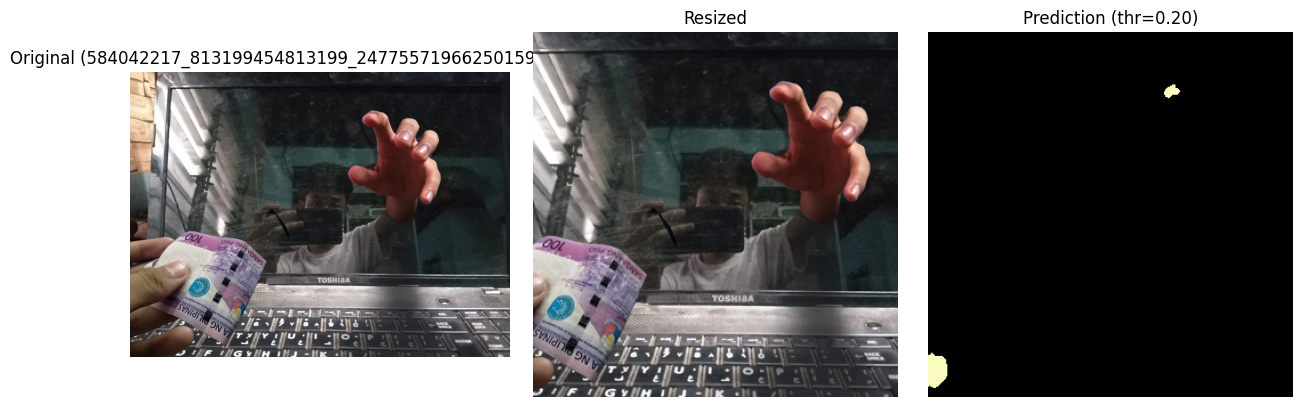

In [ ]:
from io import BytesIO
from PIL import Image, ImageOps
try:
    from google.colab import files as colab_files
except ImportError:
    colab_files = None

def _predict_image_array(image_arr: np.ndarray, checkpoint_path: Path, threshold: float) -> np.ndarray:
    from model.hybrid_forgery_detector import HybridForgeryDetector
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    cfg = HybridForgeryConfig(**checkpoint["config"]["model_config"])
    device = train_config.resolved_device()
    model = HybridForgeryDetector(cfg).to(device)
    model.load_state_dict(checkpoint["model_state"])
    model.eval()
    tensor = torch.from_numpy(image_arr.transpose(2, 0, 1)).unsqueeze(0).to(device)
    zero_noise = torch.zeros(1, 3, tensor.shape[-2], tensor.shape[-1], device=device)
    noise_inputs = {"residual": zero_noise}
    with torch.no_grad():
        mask = model.predict_mask(tensor, threshold=threshold, noise_features=noise_inputs)
    return mask.squeeze().cpu().numpy()

def _load_uploaded_image() -> tuple[Image.Image, str]:
    if USE_COLAB and colab_files is not None:
        uploaded = colab_files.upload()
        if not uploaded:
            raise ValueError("No file uploaded. Please select an image.")
        name, data = next(iter(uploaded.items()))
        return Image.open(BytesIO(data)).convert("RGB"), name
    local_image_path = Path("./REPLACE_WITH_IMAGE.jpg")
    if "REPLACE_WITH_IMAGE" in str(local_image_path):
        raise ValueError("Set local_image_path to an actual image path when running outside Colab.")
    if not local_image_path.exists():
        raise FileNotFoundError(f"Local image not found: {local_image_path}")
    return Image.open(local_image_path).convert("RGB"), str(local_image_path)

uploaded_image, uploaded_label = _load_uploaded_image()
original_image = uploaded_image.copy()
try:
    resample_mode = Image.Resampling.BICUBIC
except AttributeError:
    resample_mode = Image.BICUBIC
target_hw = (train_config.target_size, train_config.target_size)
resized_image = ImageOps.fit(uploaded_image, target_hw, method=resample_mode)
normalized = np.array(resized_image, dtype=np.float32) / 255.0
checkpoint_for_single = checkpoint_path if "checkpoint_path" in locals() else Path(train_config.checkpoint_dir) / "best.pt"
threshold_for_single = (
    best_threshold if "best_threshold" in locals()
    else (trained_config.primary_eval_threshold if "trained_config" in locals() else train_config.primary_eval_threshold)
 )
pred_mask = _predict_image_array(normalized, checkpoint_for_single, threshold_for_single)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image)
axes[0].set_title(f"Original ({uploaded_label})")
axes[0].axis("off")
axes[1].imshow(resized_image)
axes[1].set_title("Resized")
axes[1].axis("off")
axes[2].imshow(pred_mask, cmap="magma")
axes[2].set_title(f"Prediction (thr={threshold_for_single:.2f})")
axes[2].axis("off")
plt.tight_layout()
pred_mask.shape

In [ ]:
combined_manifest = Path(DATASET_ROOT) / "combined_manifest.parquet"
if combined_manifest.exists():
    # If a combined manifest file exists, pass the combined manifest file
    # itself as the prepared_root so the loader can detect and use it.
    # The loader will set per-record `prepared_root` values and write
    # caches into the manifest parent directory as needed.
    PREPARED_ROOT = str(combined_manifest)
    print(f"Found combined manifest: {combined_manifest}; using prepared manifest file: {PREPARED_ROOT}")
else:
    PREPARED_ROOT = str(DATASET_ROOT)
    print(f"Using DATASET_ROOT for prepared_root: {PREPARED_ROOT}")

train_config = TrainConfig(
    prepared_root=PREPARED_ROOT,
    train_split="train",
    val_split="val",
    target_size=384,
    batch_size=TRAIN_BATCH_SIZE,
    num_epochs=30,
    learning_rate=1e-4,
    weight_decay=1e-2,
    num_workers=DATA_WORKERS,
    prefetch_factor=PREFETCH_FACTOR,
    persistent_workers=DATA_WORKERS > 0,
    pin_memory=True,
    grad_accumulation_steps=GRAD_ACCUM_STEPS,
    grad_clip_norm=1.0,
    log_interval=10,
    checkpoint_dir=str(BASE_PATH / "checkpoints"),
    checkpoint_interval=1,
    save_best_only=True,
    use_amp=True,
    resume_from=None,
    auto_continue_latest=True,
    loss_config=loss_config,
    balance_real_fake=True,
    balanced_positive_ratio=0.6,
    eval_thresholds=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    primary_eval_threshold=0.5,
    early_stopping_patience=6,
    early_stopping_min_delta=5e-4,
)

Using DATASET_ROOT for prepared_root: /content/data


Saving 584042217_813199454813199_247755719662501594_n.jpg to 584042217_813199454813199_247755719662501594_n (2).jpg


(384, 384)

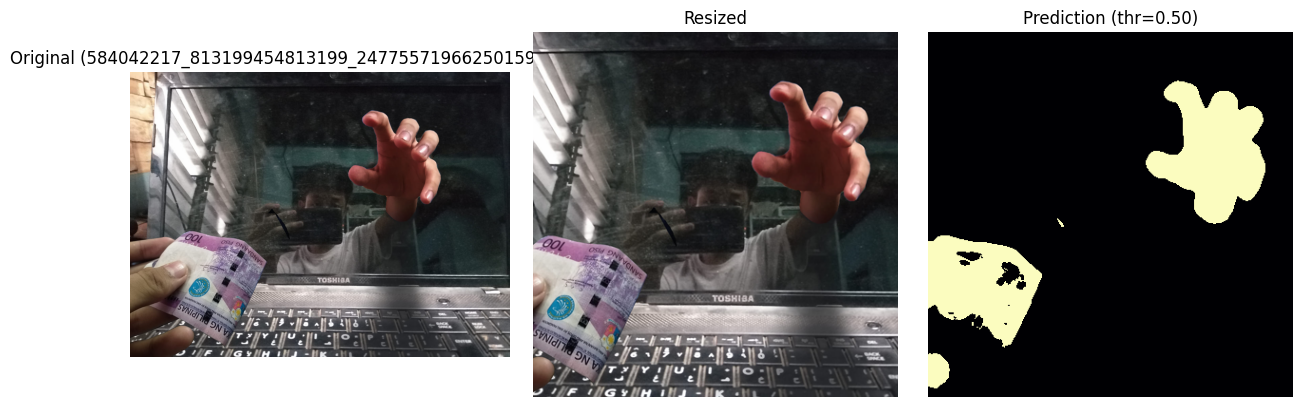

In [15]:
from io import BytesIO
from PIL import Image, ImageOps
try:
    from google.colab import files as colab_files
except ImportError:
    colab_files = None

def _predict_image_array(image_arr: np.ndarray, checkpoint_path: Path, threshold: float) -> np.ndarray:
    from model.hybrid_forgery_detector import HybridForgeryDetector
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    cfg = HybridForgeryConfig(**checkpoint["config"]["model_config"])
    device = train_config.resolved_device()
    model = HybridForgeryDetector(cfg).to(device)
    model.load_state_dict(checkpoint["model_state"])
    model.eval()
    tensor = torch.from_numpy(image_arr.transpose(2, 0, 1)).unsqueeze(0).to(device)
    zero_noise = torch.zeros(1, 3, tensor.shape[-2], tensor.shape[-1], device=device)
    noise_inputs = {"residual": zero_noise}
    with torch.no_grad():
        mask = model.predict_mask(tensor, threshold=threshold, noise_features=noise_inputs)
    return mask.squeeze().cpu().numpy()

def _load_uploaded_image() -> tuple[Image.Image, str]:
    if USE_COLAB and colab_files is not None:
        uploaded = colab_files.upload()
        if not uploaded:
            raise ValueError("No file uploaded. Please select an image.")
        name, data = next(iter(uploaded.items()))
        return Image.open(BytesIO(data)).convert("RGB"), name
    local_image_path = Path("./REPLACE_WITH_IMAGE.jpg")
    if "REPLACE_WITH_IMAGE" in str(local_image_path):
        raise ValueError("Set local_image_path to an actual image path when running outside Colab.")
    if not local_image_path.exists():
        raise FileNotFoundError(f"Local image not found: {local_image_path}")
    return Image.open(local_image_path).convert("RGB"), str(local_image_path)

uploaded_image, uploaded_label = _load_uploaded_image()
original_image = uploaded_image.copy()
try:
    resample_mode = Image.Resampling.BICUBIC
except AttributeError:
    resample_mode = Image.BICUBIC
target_hw = (train_config.target_size, train_config.target_size)
resized_image = ImageOps.fit(uploaded_image, target_hw, method=resample_mode)
normalized = np.array(resized_image, dtype=np.float32) / 255.0
checkpoint_for_single = checkpoint_path if "checkpoint_path" in locals() else "/content/drive/MyDrive/LIFD.bak/checkpoints/best.pt"
threshold_for_single = (
    best_threshold if "best_threshold" in locals()
    else (trained_config.primary_eval_threshold if "trained_config" in locals() else train_config.primary_eval_threshold)
 )
pred_mask = _predict_image_array(normalized, checkpoint_for_single, threshold_for_single)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image)
axes[0].set_title(f"Original ({uploaded_label})")
axes[0].axis("off")
axes[1].imshow(resized_image)
axes[1].set_title("Resized")
axes[1].axis("off")
axes[2].imshow(pred_mask, cmap="magma")
axes[2].set_title(f"Prediction (thr={threshold_for_single:.2f})")
axes[2].axis("off")
plt.tight_layout()
pred_mask.shape